# Load the data into pandas and do some analysis

In [1]:
#I'm using an old python, because the tensorflow wheels aren't available for 3.9+
!python --version

Python 3.6.11


In [2]:
# Ran this before starting the notebook
!pip install -r ../requirements.txt  --use-deprecated=legacy-resolver > /dev/null

# Load data set into pyarrow and pandas.

This will let us do some analysis on the data and perhaps some feature engineering. First, we just want to make sure we're logging the data properly.

In [3]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import tensorflow as tf
import pyarrow.compute as pc

In [4]:
# Uncomment the following to disable GPU
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")

In [6]:
table = ds.read()

In [7]:
#print(table)

In [8]:
table.num_rows

865900

In [9]:
dummy = pc.sort_indices(table, sort_keys=[('timestamp', 'descending')])

In [10]:
ptable = table.to_pandas()

In [11]:
print(ptable)

           timestamp label                                            cpuinfo  \
0       1.637617e+09     1  [2800.0, 2800.0, 2174.128, 2800.0, 2800.0, 280...   
1       1.637617e+09     1  [2800.0, 2800.0, 1357.127, 2800.0, 2800.0, 280...   
2       1.637617e+09     1  [2800.0, 2800.0, 2762.186, 2800.0, 2800.0, 280...   
3       1.637617e+09     1  [2800.0, 2800.0, 1379.557, 2800.0, 2800.0, 280...   
4       1.637617e+09     1  [2800.0, 2800.0, 2800.0, 1898.875, 2800.0, 280...   
...              ...   ...                                                ...   
865895  1.637727e+09     1  [2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800....   
865896  1.637727e+09     1  [2800.0, 2800.0, 2800.0, 1313.665, 1684.526, 2...   
865897  1.637727e+09     1  [2800.0, 2081.427, 2800.0, 2800.0, 2800.0, 280...   
865898  1.637727e+09     1  [2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 1402....   
865899  1.637727e+09     1  [2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 1468....   

       profile             

In [12]:
max(ptable['power'])

array([44.170254], dtype=float32)

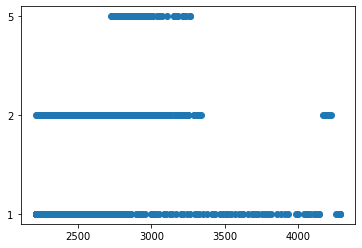

In [13]:
import matplotlib.pyplot as plt
plt.scatter(ptable['fan_rpm'], ptable['label'])

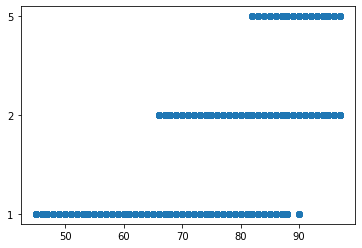

In [14]:
max_temp = ptable['temp'].apply(lambda a: max(a))
plt.scatter(max_temp, ptable['label'])

In [15]:
from statistics import mean
mean_temp = ptable['temp'].apply(lambda a: mean(a))

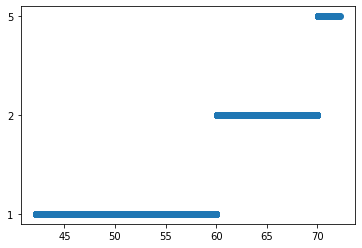

In [16]:
plt.scatter(mean_temp, ptable['label'])

The above is exactly what we would expect since we set the fan speed, aka label, based on the current mean temperature.

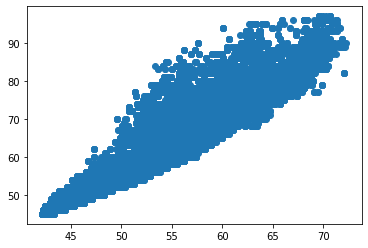

In [17]:
plt.scatter(mean_temp, max_temp)

As expected we see a high correlation between mean and max temperature.

In [18]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)
power = ptable['power'].apply(lambda a: clamp(a[0], 0.0, 99.0))

In [19]:
import statistics
print(statistics.mean(power))
print(statistics.median(power))
print(statistics.variance(power))

6.958980908701417
6.801417589187622
4.329467813783393


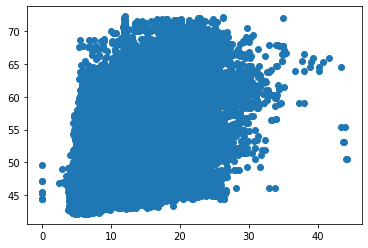

In [20]:
plt.scatter(power, mean_temp)

This shows there is some correlation between current wattage and mean measured temperature. Which one might expect. :)

Lets see the distribution of idleness. Presumably we have a lot of samples of when the CPU is cold and not doing much.
We'll have to either weigh our samples or resample the data if we want to use this data for training an ML model.

In [21]:
cpu_idle = ptable['cpu_idle'].apply(lambda a: mean(a))

In [22]:
import seaborn as sns

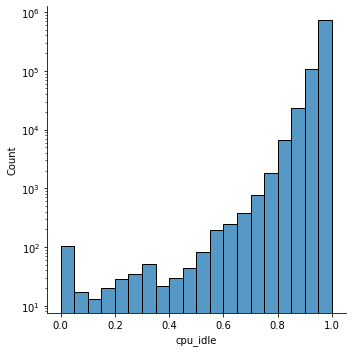

In [23]:
sns.displot(cpu_idle, binwidth=0.05, log=True)

Our idlenes assumption appears to be backed up by reality.

Let's see how strong the correlation is between idleness and temperature.
And idleness and power.

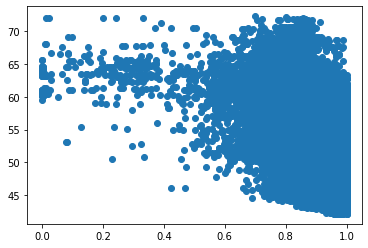

In [24]:
plt.scatter(cpu_idle, mean_temp)

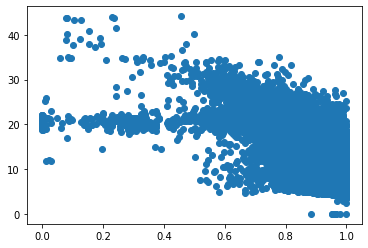

In [25]:
plt.scatter(cpu_idle, power)

There is an inverse correlation as one would expect, but it doesn't appear to be all that strong.